In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from PyDictionary import PyDictionary

from sklearn.decomposition import PCA
import torch

# from llama import Dialog, Llama

import matplotlib as mpl 
import matplotlib.colors as mcolors
mpl.rcParams['text.usetex'] = True
# Set the global font to be Times New Roman, size 11
mpl.rc('font', family='Times New Roman', size=11)

# Testing the generalisation of the "lie detector"

Train PCA / model on (un)known words and test on (un)known names.

For data1, the promts are:
- __"Always respond with a SINGLE date. You are given the name of a personality, give me it's date of birth. \n Nicolaus Copernicus: 1473 \n Ed Sheeran: 1991 \n Angela Merkel: 1954 \n Victor Hugo: 1802 "__
- __"Always respond with a SINGLE word. You are given an english word, give me a Synonym. \n Cloud: Nebula \n Bridge: Span \n Cup: Mug \n Service: Assistance"__

For data2, the promts are:
- __"Always respond with a SINGLE sentence. You are given the name of a personality, give me a short description."__
- __"Always respond with a SINGLE sentence. You are given an english word, give me a short definition"__

In [2]:
with open("data1_inference_date_fake.pkl", "rb") as fp:
    date_fake_list = pickle.load(fp)

with open("data1_inference_date_real.pkl", "rb") as fp:
    date_real_list = pickle.load(fp)

with open("data1_inference_syn_fake.pkl", "rb") as fp:
    syn_fake_list = pickle.load(fp)

with open("data1_inference_syn_real.pkl", "rb") as fp:
    syn_real_list = pickle.load(fp)

with open("data1_inference_election_2024.pkl", "rb") as fp:
    election2024 = pickle.load(fp)

with open("data1_inference_election_2010.pkl", "rb") as fp:
    election2010 = pickle.load(fp)


In [3]:
def gather_norm_acts(data):
    list_norm_act = []
    # For each dataset element (words)
    for word_id in range(len(data)):
        list_norm_act.append([])
        # For the subset of selected layers in the dictionaray
        for layer_nb in data[word_id]["hook"].keys():
            list_norm_act[word_id].append(data[word_id]["hook"][layer_nb]["normalized"])
    return list_norm_act

# Selecting last element of the generation - AKA the Yes generation or No generation
date_fake_act = gather_norm_acts(date_fake_list)
date_real_act = gather_norm_acts(date_real_list)
syn_fake_act = gather_norm_acts(syn_fake_list)
syn_real_act = gather_norm_acts(syn_real_list)
election2024_act = gather_norm_acts(election2024)
election2010_act = gather_norm_acts(election2010)

print("Just a list of layer size with each embedding size vector")
print(len(date_fake_act))          # Size of word dataset
print(len(date_fake_act[0]))       # Size of layer (subset)
print(len(date_fake_act[0][0]))    # Size of output
print(len(date_fake_act[0][0][0])) # Size of enbedding

Just a list of layer size with each embedding size vector
66
32
1
4096


In [4]:
def flat_data(data, words, layers, tokens):
    data = [data[w][l][t] for w in words for l in layers for t in tokens]

    return data

# Creating labels of the existance of words

In [5]:
# Word check
dictionary = PyDictionary()
no_label = []
yes_label = []

def word_exists(word):
    meaning = dictionary.meaning(word)
    return meaning is not None

for i in range(len(data_no_list)):
    input_nature = word_exists(data_no_list[i]["input"])
    output_nature = word_exists(data_no_list[i]["output"])

    print("{}: input {} is {} -> \t \t output {} is {}".format(i, data_no_list[i]["input"], input_nature, data_no_list[i]["output"], output_nature))
    no_label.append([input_nature, output_nature])

for i in range(len(data_yes_list)):
    input_nature = word_exists(data_yes_list[i]["input"])
    output_nature = word_exists(data_yes_list[i]["output"])

    print("{}: input {} is {} -> \t \t output {} is {}".format(i, data_yes_list[i]["input"], input_nature, data_yes_list[i]["output"], output_nature))
    yes_label.append([input_nature, output_nature])

NameError: name 'data_no_list' is not defined

TypeError: Invalid shape (0,) for image data

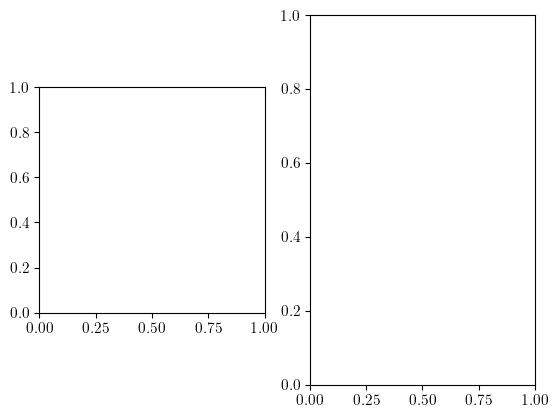

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.array(no_label));
# ax[0].title("labels of the fake word generation")
ax[1].imshow(np.array(yes_label))
# ax[1].title("labels of the real word generation")

plt.show()

In [8]:
# color_selction = ["gold", "orange", "pink", "purple"]
color_selction = ["#ef6c00", "#eeff41", "#009668", "#ce93d8" , "#a1e8d9", "#b3a77d", "#6a634a"]

def simple_label2color(label):
    # labels are 4 choices
    color = color_selction[label]
    return color

def bidim_label2color(label):
    # labels are 2*2*2 choices
    color = color_selction[label[1] + 2*label[2]]
    # color = mcolors.CSS4_COLORS[color_selction[label[1] + 2*label[2]]]
    return color

# Test comparaison of data process: Trained on __Words__ Tested on __Names__

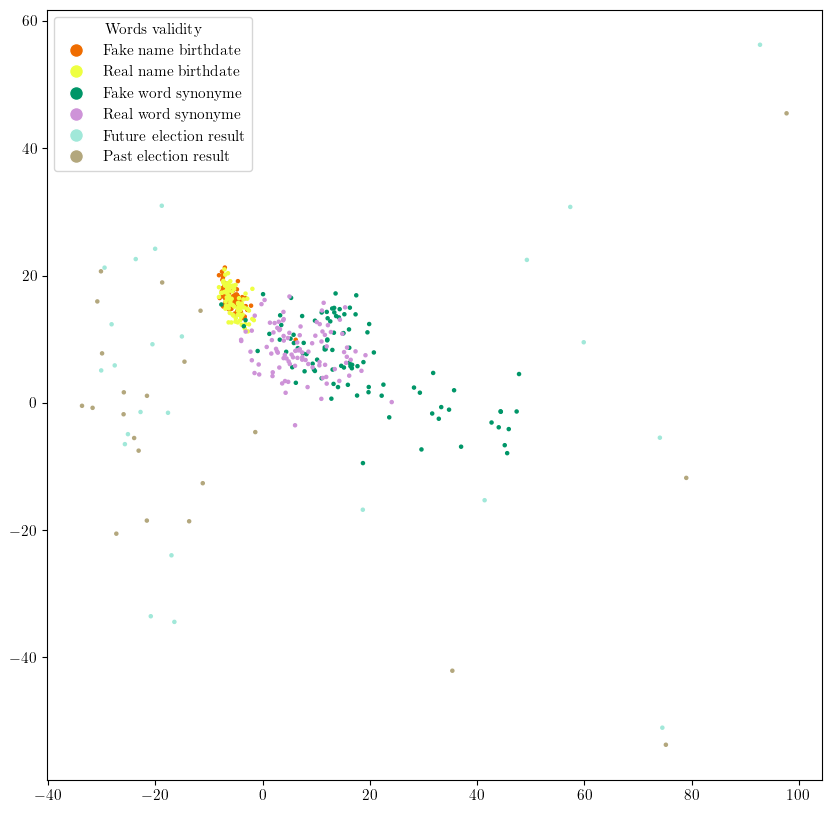

In [20]:
label_colors = \
    [simple_label2color(0) for _ in range(len(date_fake_act))] + \
    [simple_label2color(1) for _ in range(len(date_real_act))] + \
    [simple_label2color(2) for _ in range(len(syn_fake_act))] + \
    [simple_label2color(3) for _ in range(len(syn_real_act))] + \
    [simple_label2color(4) for _ in range(len(election2024_act))] + \
    [simple_label2color(5) for _ in range(len(election2010_act))]

layer_nb = 16

# Gather the list correctly
date_fake_states = torch.stack(flat_data(date_fake_act, range(len(date_fake_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
date_real_states = torch.stack(flat_data(date_real_act, range(len(date_real_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
syn_fake_states = torch.stack(flat_data(syn_fake_act, range(len(syn_fake_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
syn_real_states = torch.stack(flat_data(syn_real_act, range(len(syn_real_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
# Elections
election2024_state = torch.stack(flat_data(election2024_act, range(len(election2024_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
election2010_state = torch.stack(flat_data(election2010_act, range(len(election2010_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()

# Train on one problem
pca = PCA(n_components=2)
X = np.concatenate([election2024_state, election2010_state])
pca.fit(X)
# Apply transformation to other problem
X = np.concatenate([date_fake_states, date_real_states, syn_fake_states, syn_real_states, election2024_state, election2010_state])  
x = pca.transform(X)

plt.figure(figsize=(10, 10), dpi=100)
scatter = plt.scatter(x[:, 0], x[:, 1], c=label_colors, s=5)

legend_labels = ["Fake name birthdate", "Real name birthdate", "Fake word synonyme", "Real word synonyme", "Future election result", "Past election result"]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in color_selction]
plt.legend(legend_handles, legend_labels, title="Words validity", loc='upper left')


plt.savefig("Multigen_generalisation_conterexemple.png")
plt.show()

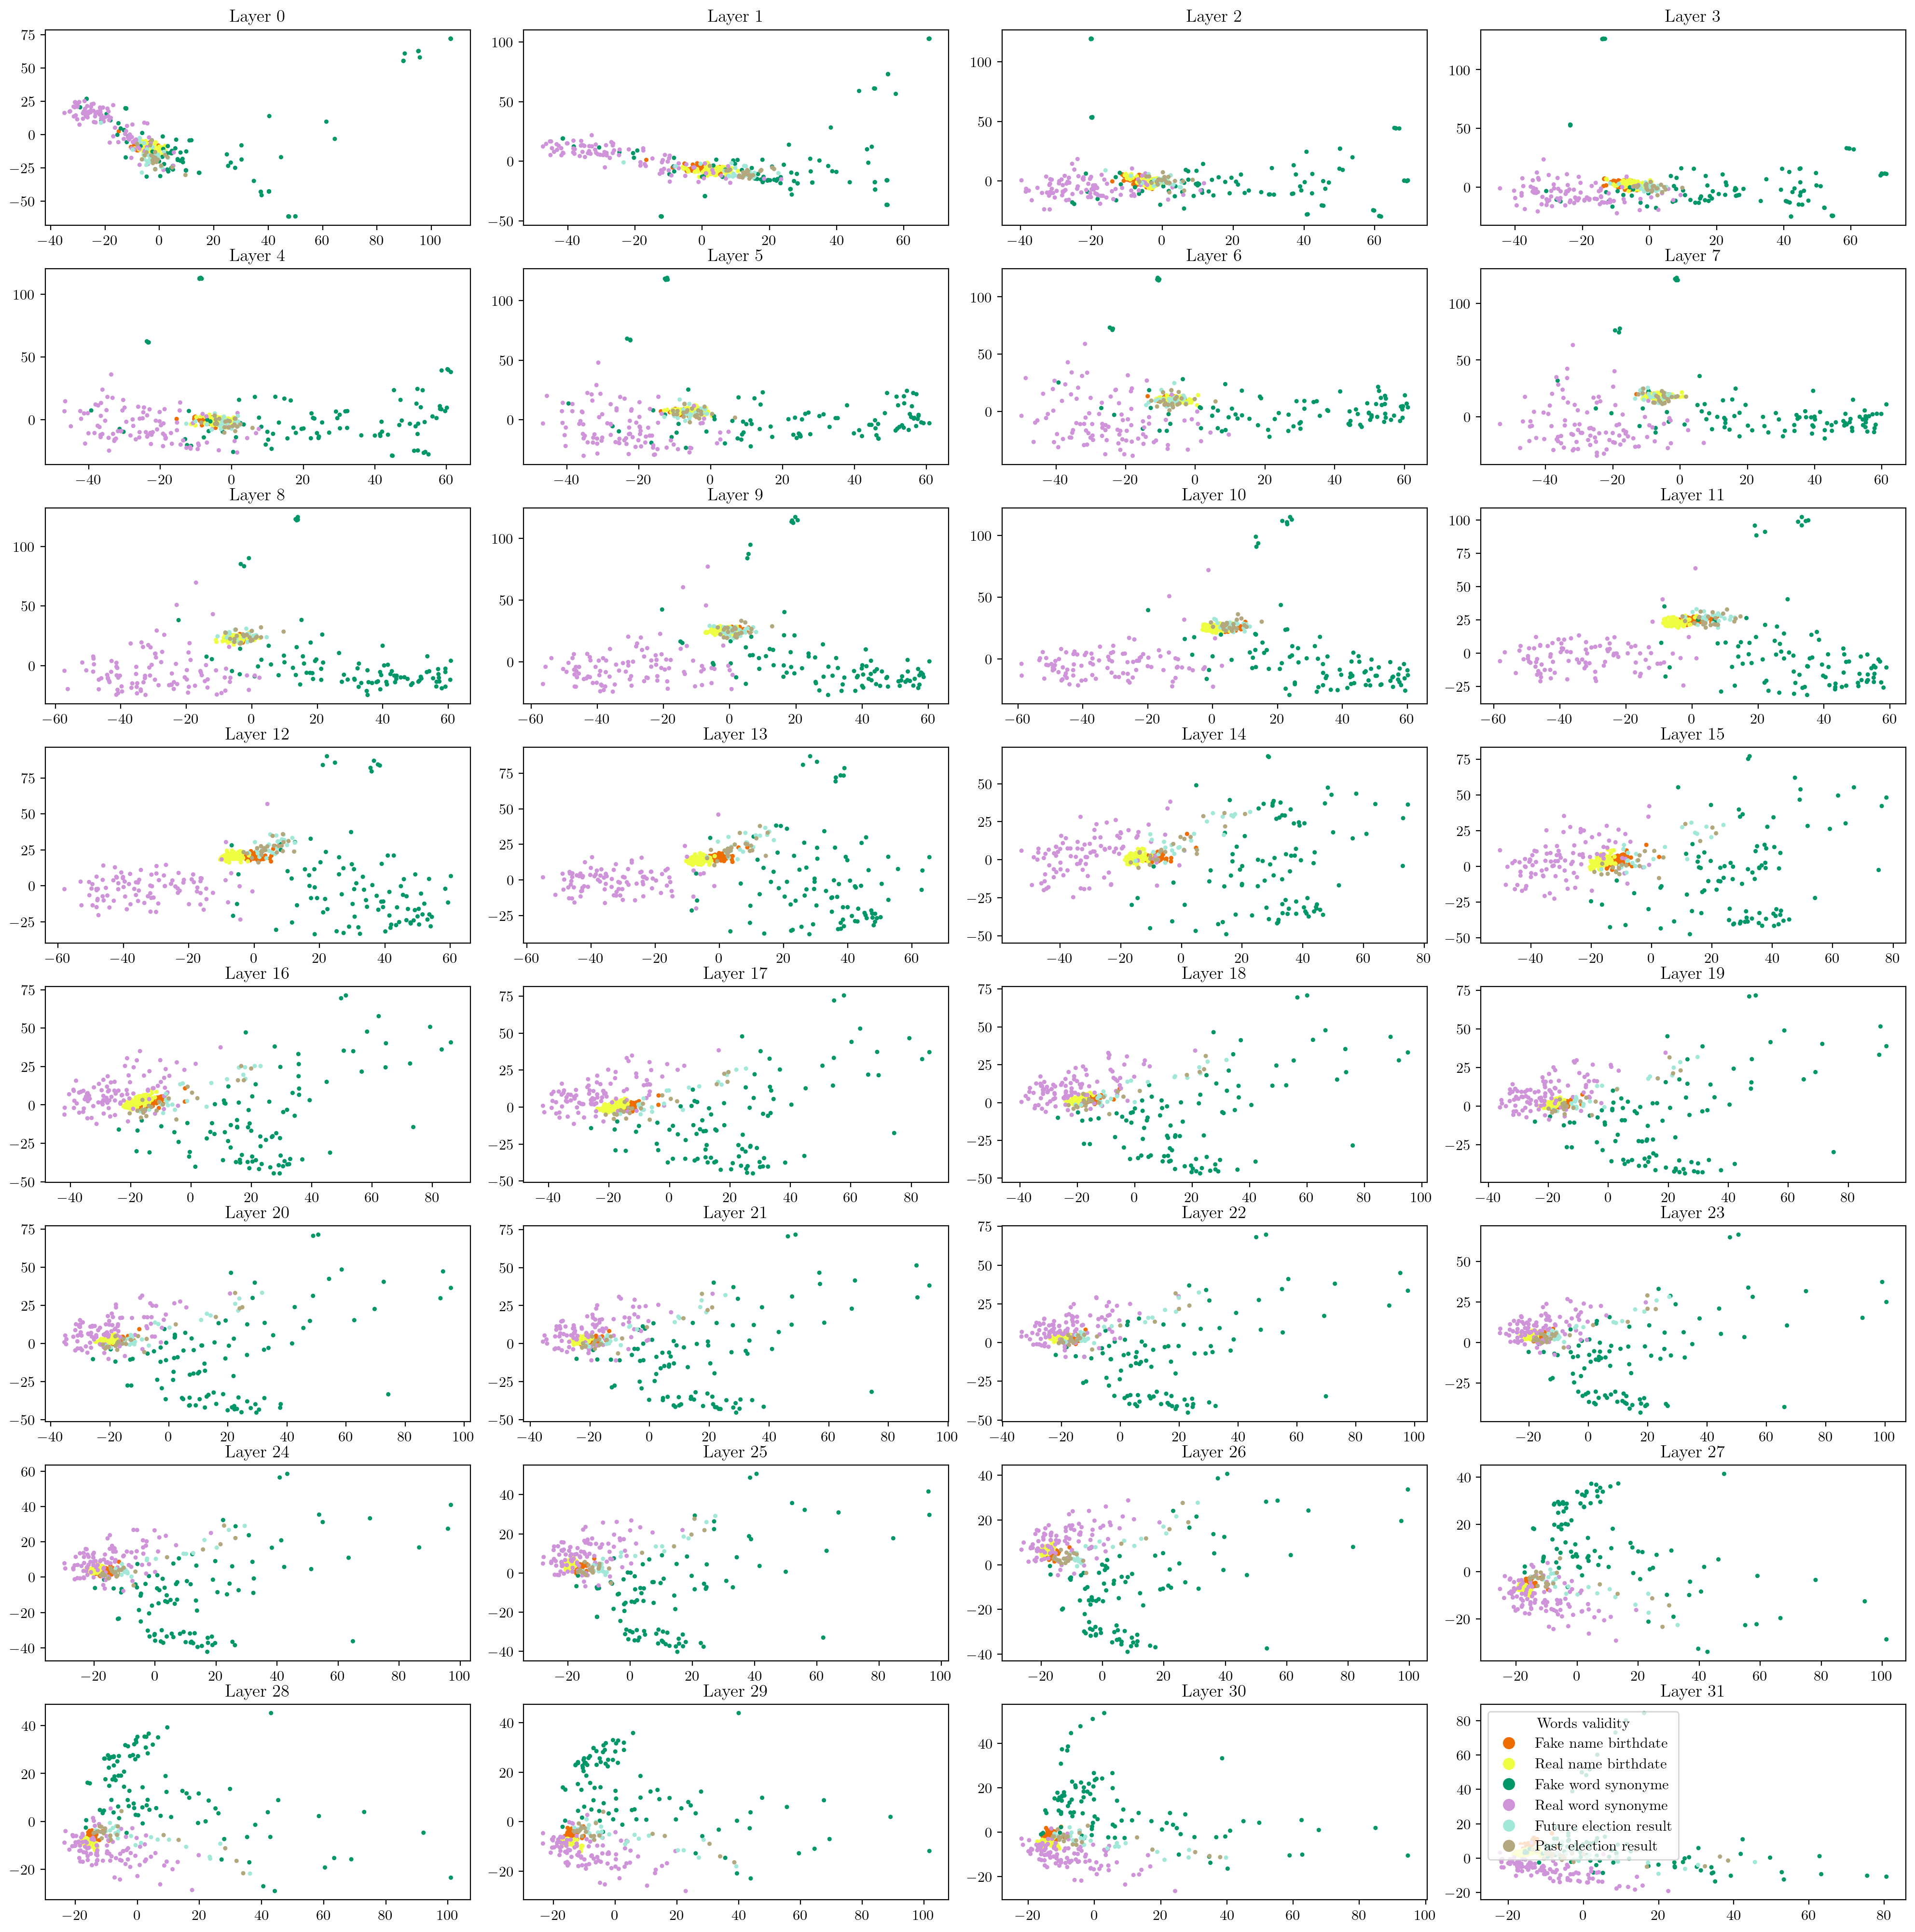

In [10]:
fig, ax = plt.subplots(8,4, figsize=(20, 20), dpi=200)

fig.tight_layout()

for layer_nb in range(32):

    # Gather the list correctly
    date_fake_states = torch.stack(flat_data(date_fake_act, range(len(date_fake_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
    date_real_states = torch.stack(flat_data(date_real_act, range(len(date_real_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
    syn_fake_states = torch.stack(flat_data(syn_fake_act, range(len(syn_fake_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
    syn_real_states = torch.stack(flat_data(syn_real_act, range(len(syn_real_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
    election2024_state = torch.stack(flat_data(election2024_act, range(len(election2024_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()
    election2010_state = torch.stack(flat_data(election2010_act, range(len(election2010_act)), [layer_nb], [-1])).type(torch.float64).cpu().numpy()

    pca = PCA(n_components=2)
    X = np.concatenate([syn_fake_states, syn_real_states])
    pca.fit(X)
    # Apply transformation to other problem
    X = np.concatenate([date_fake_states, date_real_states, syn_fake_states, syn_real_states, election2024_state, election2010_state])
    x = pca.transform(X)


    ax[layer_nb//4][layer_nb%4].scatter(x[:, 0], x[:, 1], c=label_colors, s=5)
    ax[layer_nb//4][layer_nb%4].set_title("Layer {}".format(layer_nb))

# legend_labels = ["Fake name Bio", "Real name Bio", "Fake word definition", "Real word definition"]
legend_labels = ["Fake name birthdate", "Real name birthdate", "Fake word synonyme", "Real word synonyme", "Future election result", "Past election result"]

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in color_selction]
plt.legend(legend_handles, legend_labels, title="Words validity", loc='upper left')


plt.savefig("Multigen_generalisation_words2names_multilayer.png")
plt.show()